The dataset used in this project, *BlackFriday.csv*, was downloaded from [Kaggle](https://www.kaggle.com/mehdidag/black-friday).

# Background
This dataset contains samples of transactions made in a retail store on Black Friday. The main goal of this project is to train a model that can predict ***Purchase*** given (old or new) customers' information. Such information is invaluable for stores as it can serve as a solid foundation for more effective future sales/marketing strategies to maximize their profits. 

<img src="figure/bf_figure1.png" width="40%" class="center"></img>

First, the entire dataset will be explored through EDA. Then, it is going be a straightforward regression problem where the model performance is evaluated by root mean squared error (RMSE). This project will focus on a step-by-step Random Forest model development process, rather than intensely seaching for optimized hyperparameters and better training models.

#### Import dataset and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('dataset_BlackFriday/BlackFriday.csv')

# Quick overview of the data
#### Dataset structure

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB
None


#### Checking for missing values

In [5]:
print('<Contain NaNs?>')
print(df.isnull().any())
missing_ser_percentage = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
missing_ser_percentage = missing_ser_percentage[missing_ser_percentage!=0].round(2)
missing_ser_percentage.name = 'missing values %'
print('\n<NaN ratio>')
print(missing_ser_percentage)

<Contain NaNs?>
User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool

<NaN ratio>
Product_Category_3    69.44
Product_Category_2    31.06
Name: missing values %, dtype: float64


#### Filling the missing values

In [6]:
df.fillna(0,inplace=True)

#### Unique element in each column

In [7]:
for col in df.columns:
    print('{} unique element: {}'.format(col,df[col].nunique()))

User_ID unique element: 5891
Product_ID unique element: 3623
Gender unique element: 2
Age unique element: 7
Occupation unique element: 21
City_Category unique element: 3
Stay_In_Current_City_Years unique element: 5
Marital_Status unique element: 2
Product_Category_1 unique element: 18
Product_Category_2 unique element: 18
Product_Category_3 unique element: 16
Purchase unique element: 17959


This dataset has 537577 entries with 12 columns. It is a lot of data (~half million) that contains customer-specific (`User_ID`) and product-specific (`Product_ID`,`Product_Category_1`,`Product_Category_2`,`Product_Category_3`) information. The unique `User_ID` and `Product_ID` are ~5900 and ~3600, respectively. They are quite small compared to the total number of entries, therefore, it can be inferred that a great portion of `User_ID` and `Product_ID` repeat many times and they may contain crucial information. **However**, these information are only available when the target variable, `Purchase`, is determined at the cashier. Therefore, training the data using these information may cause undersirable **data leakage** depending on the goal of the project. The store may want to predict `Purchase` soley based on the low-level information (i.e. `Gender`, `Age`, etc) so that they can reflect those in their marketing strategies that target new customers. 

In this project, both cases will be considered and two separate models will be trained for comparison.
* Case 1: Training with all features (including customer- and product- specific information)
* Case 2: Training with low-level features only

A brief investigation revealed that ~31% and ~69% data are NaNs in ***Product_Category_2*** and ***Product_Categroy_3***, respectively. As the datatype of `Product_Category_1` is *int*, these NaNs were filled with 0.

Lastly, it should be noted that most features are categorical.

# EDA

#### Purchase distribution

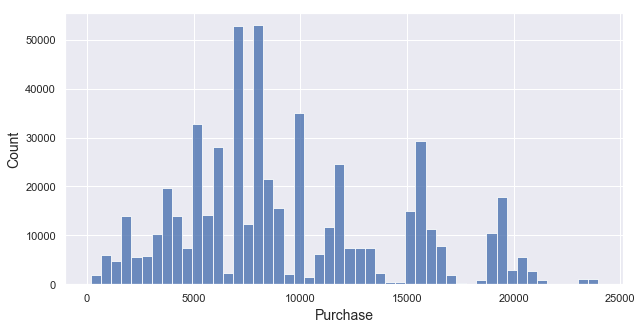

In [8]:
plt.figure(figsize=(10,5))
plt.hist(df['Purchase'],bins=50, alpha=0.8)
plt.xlabel('Purchase',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

The target varaible is slightly right skewed, but looks more or less like normal.
#### Distributions of `User_ID` and `Product_ID`

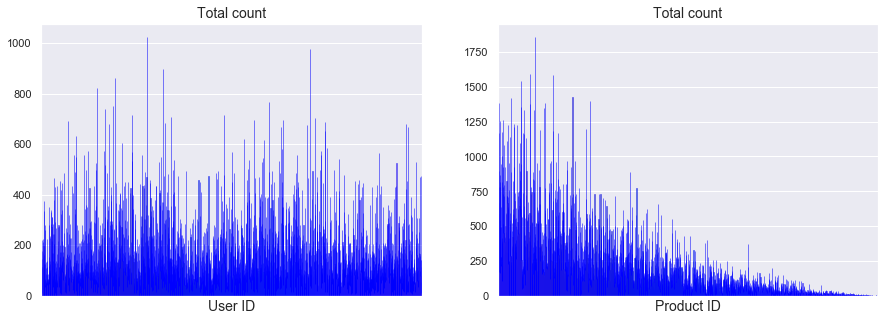

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(df['User_ID'],edgecolor='blue',alpha=0.5)
plt.xlabel('User ID',fontsize=14)
plt.ylabel('')
plt.title('Total count',fontsize=14)
plt.xticks([])
plt.subplot(122)
sns.countplot(df['Product_ID'],edgecolor='blue',alpha=0.5)
plt.xlabel('Product ID',fontsize=14)
plt.ylabel('')
plt.title('Total count',fontsize=14)
plt.xticks([])
plt.show()

These distributions shows that if the model is trained for these customer- and product-specific information, it will help predicting `Purchase`. This can be seen in more detail in the figures below.
#### Average purchase by `User_ID`

<Figure size 1440x360 with 0 Axes>

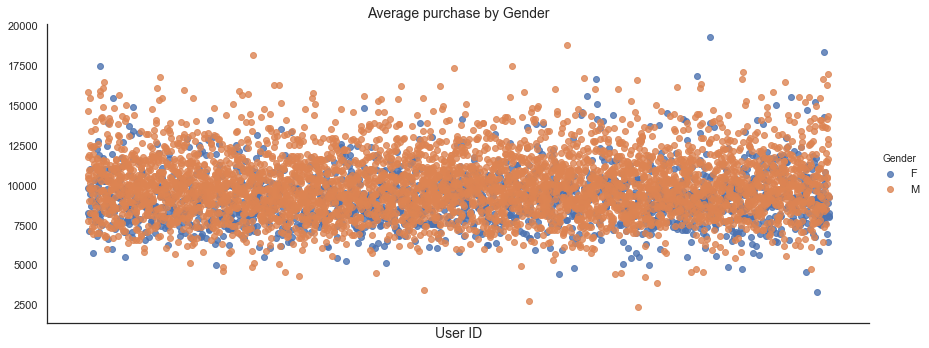

<Figure size 1440x360 with 0 Axes>

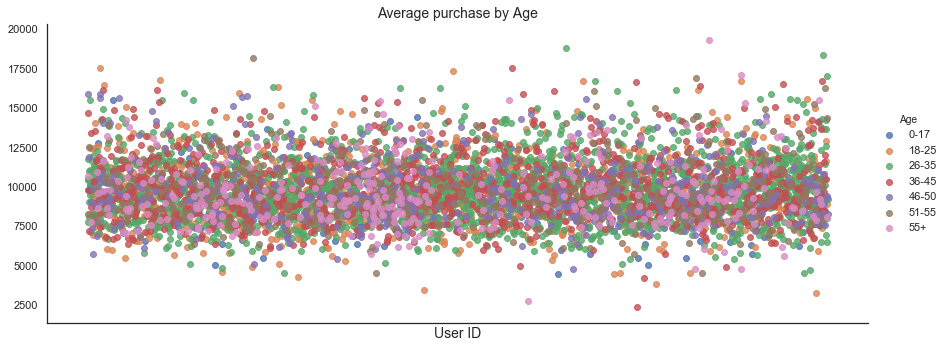

In [10]:
sns.set_style('white')
df_Apurchase_by_UID_Gender = df.groupby(['User_ID','Gender']).agg({'Purchase':np.mean}).reset_index()
df_Apurchase_by_UID_Age = df.groupby(['User_ID','Age']).agg({'Purchase':np.mean}).reset_index()
age_order = ['0-17','18-25','26-35','36-45','46-50','51-55','55+']

plt.figure(figsize=(20,5))
sns.lmplot('User_ID','Purchase',data=df_Apurchase_by_UID_Gender,fit_reg=False,hue='Gender',aspect=2.5)
plt.xticks([])
plt.xlabel('User ID',fontsize=14)
plt.ylabel('')
plt.title('Average purchase by Gender',fontsize=14)
plt.show()
plt.figure(figsize=(20,5))
sns.lmplot('User_ID','Purchase',data=df_Apurchase_by_UID_Age,fit_reg=False,hue='Age',hue_order=age_order,aspect=2.5)
plt.xticks([])
plt.xlabel('User ID',fontsize=14)
plt.ylabel('')
plt.title('Average purchase by Age',fontsize=14)
plt.show()

#### Average purchase by `Product_ID`

<Figure size 1440x360 with 0 Axes>

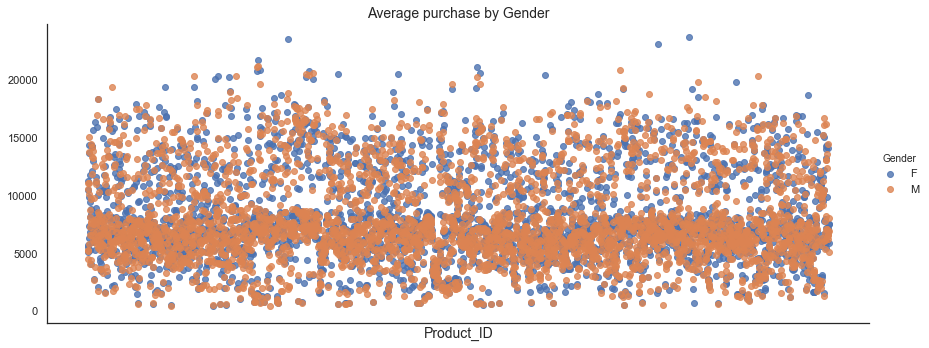

<Figure size 1440x360 with 0 Axes>

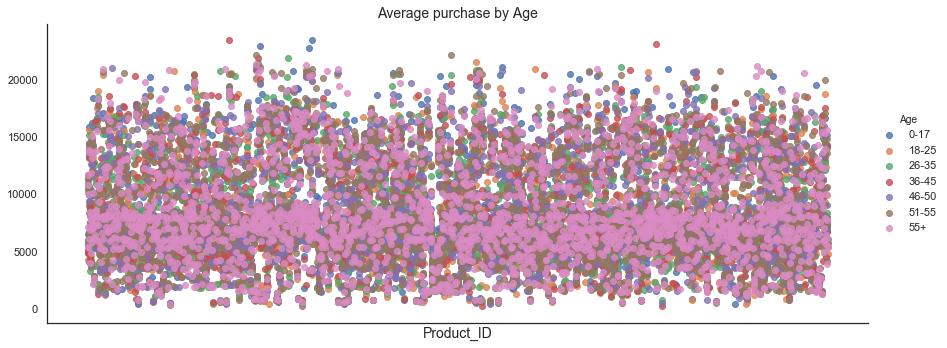

In [11]:
df_Apurchase_by_PID_Gender = df.groupby(['Product_ID','Gender']).agg({'Purchase':np.mean}).reset_index()
le_P_ID = LabelEncoder()
df_Apurchase_by_PID_Gender['Product_ID'] = le_P_ID.fit_transform(df_Apurchase_by_PID_Gender['Product_ID'])
df_Apurchase_by_PID_Age = df.groupby(['Product_ID','Age']).agg({'Purchase':np.mean}).reset_index()
df_Apurchase_by_PID_Age['Product_ID'] = le_P_ID.fit_transform(df_Apurchase_by_PID_Age['Product_ID'])

plt.figure(figsize=(20,5))
sns.lmplot('Product_ID','Purchase',data=df_Apurchase_by_PID_Gender,fit_reg=False,hue='Gender',aspect=2.5)
plt.xticks([])
plt.xlabel('Product_ID',fontsize=14)
plt.ylabel('')
plt.title('Average purchase by Gender',fontsize=14)
plt.show()
plt.figure(figsize=(20,5))
sns.lmplot('Product_ID','Purchase',data=df_Apurchase_by_PID_Age,fit_reg=False,hue='Age',hue_order=age_order,aspect=2.5)
plt.xticks([])
plt.xlabel('Product_ID',fontsize=14)
plt.ylabel('')
plt.title('Average purchase by Age',fontsize=14)
plt.show()

Certainly, specific users and products are contributing more in terms of `Purchase`. Based on these figures, `Product_ID` seems to have stronger predictive power than `User_ID`. 

####  Count/Purchase by Age by Gender

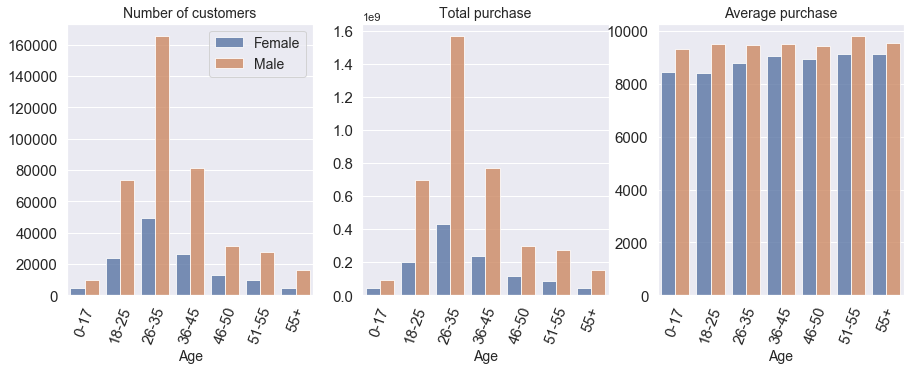

In [12]:
sns.set_style('darkgrid')

plt.figure(figsize=(15,5))
plt.subplot(131)
sns.countplot('Age',order=age_order,hue='Gender',data=df,alpha = 0.8)
plt.xlabel('Age',fontsize=14)
plt.ylabel('')
plt.xticks(rotation=70)
plt.title('Number of customers',fontsize=14)
plt.legend(['Female','Male'],frameon=True,fontsize=14)
plt.tick_params(labelsize=15)
plt.subplot(132)
df_Tpurchase_by_Age = df.groupby(['Age','Gender']).agg({'Purchase':np.sum}).reset_index()
sns.barplot('Age','Purchase',hue='Gender',data=df_Tpurchase_by_Age,alpha = 0.8)
plt.xlabel('Age',fontsize=14)
plt.ylabel('')
plt.xticks(rotation=70)
plt.title('Total purchase',fontsize=14)
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)
plt.subplot(133)
df_Apurchase_by_Age = df.groupby(['Age','Gender']).agg({'Purchase':np.mean}).reset_index()
sns.barplot('Age','Purchase',hue='Gender',data=df_Apurchase_by_Age,alpha = 0.8)
plt.xlabel('Age',fontsize=14)
plt.ylabel('')
plt.xticks(rotation=70)
plt.title('Average purchase',fontsize=14)
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)

In both gender, the age group that purchased most was [26-35]. The total number of customers who made transactions and their total purchase amount were very strongly correlated. This was well reflected in the thrid subplot where the average purchase appeared to be very similiar in all different age groups. In other words, the total purchase of [26-35] was the most simply because there were more customers in that age group. This may mean that ***Age*** may not be a strong predictor for ***Purchase***. However, ***Gender*** may be helpful as it was clear that Male spent more than Female.

Assuming the Gender ratio to be simliar in each city, different city may have different occupation distribution. If that is the case, the ***city*** that the customer comes from may be a strong predictor for ***Purchase*** as customers with certain occupations may spend more during shopping. 

####  Count/Purchase by City by Occupation

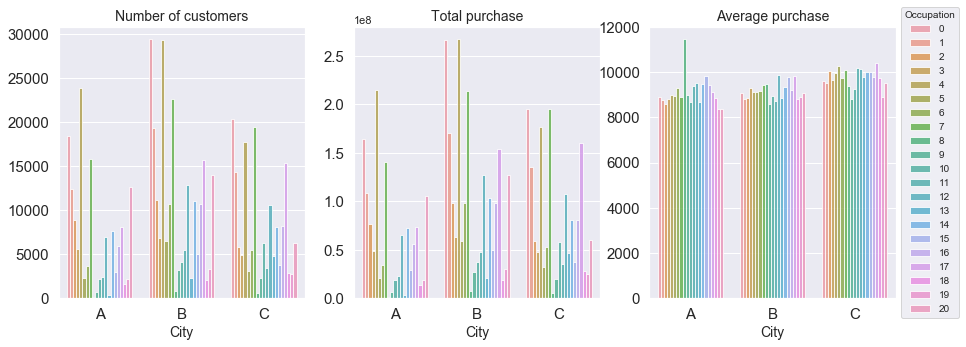

In [13]:
city_order = ['A','B','C']
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.countplot('City_Category',order=city_order,hue='Occupation',data=df,alpha = 0.8)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)
plt.title('Number of customers',fontsize=14)
plt.subplot(132)
df_Tpurchase_by_City = df.groupby(['City_Category','Occupation']).agg({'Purchase':np.sum}).reset_index()
sns.barplot('City_Category','Purchase',hue='Occupation',data=df_Tpurchase_by_City,alpha = 0.8)
plt.title('Total purchase',fontsize=14)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)
plt.subplot(133)
df_Apurchase_by_City = df.groupby(['City_Category','Occupation']).agg({'Purchase':np.mean}).reset_index()
sns.barplot('City_Category','Purchase',hue='Occupation',data=df_Apurchase_by_City,alpha = 0.8)
plt.title('Average purchase',fontsize=14)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend(title='Occupation',frameon=True,fontsize=10,bbox_to_anchor=(1,0.5), loc="center left")
plt.tick_params(labelsize=15)

However, in each city, the occupation distribution was quite similar. As observed in the age distribution above, the number of customers and total purchase amounts from customers in different occupations in each city showed strong correlation. This was also well reflected in the last subplot where the average purchase was similiar in all different groups of consideration. One thing to be noted was that the average purchase of customers with *Occupation #8* from *City A* showed distinctively high average purchase.

Other features can also be investigated in terms of `Purchase`.

####  Purchase by City by Marrital status and Residency duration

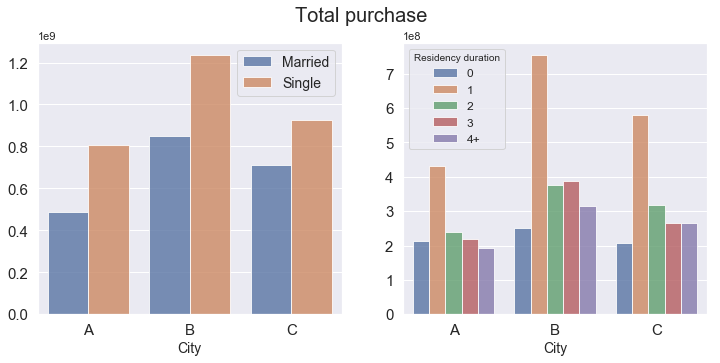

In [14]:
df['Marital_Status_label']=np.where(df['Marital_Status'] == 0,'Single','Married')
df_Tpurchase_by_City_Marital = df.groupby(['City_Category','Marital_Status_label']).agg({'Purchase':np.sum}).reset_index()
df_Tpurchase_by_City_Stay = df.groupby(['City_Category','Stay_In_Current_City_Years']).agg({'Purchase':np.sum}).reset_index()
fig = plt.figure(figsize=(12,5))
fig.suptitle('Total purchase',fontsize=20)
plt.subplot(121)
sns.barplot('City_Category','Purchase',hue='Marital_Status_label',data=df_Tpurchase_by_City_Marital,alpha = 0.8)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend(frameon=True,fontsize=14)
plt.tick_params(labelsize=15)
plt.subplot(122)
sns.barplot('City_Category','Purchase',hue='Stay_In_Current_City_Years',data=df_Tpurchase_by_City_Stay,alpha = 0.8)
plt.xlabel('City',fontsize=14)
plt.ylabel('')
plt.legend(title='Residency duration',frameon=True,fontsize=12,loc=2)
plt.tick_params(labelsize=15)
df.drop('Marital_Status_label',axis=1,inplace=True)

It was shown that unmarried customers spent more than the married. Customers who lived in their city for 1 year tent to spend more than other groups.   

Also, it would be interesting to find the ***Product_Category_1*** that was the most famous. 
####  Count/Purchase by Product_Category_1 by Age and Gender

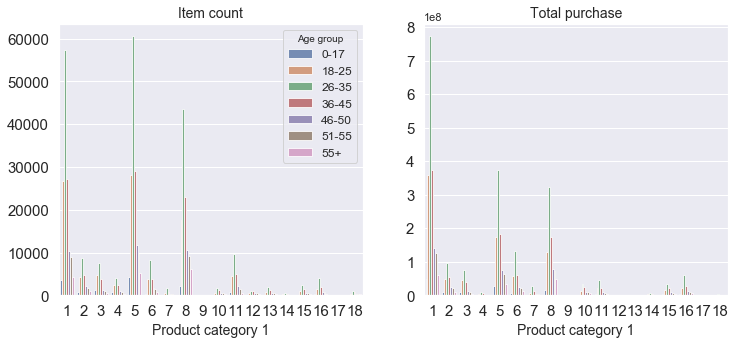

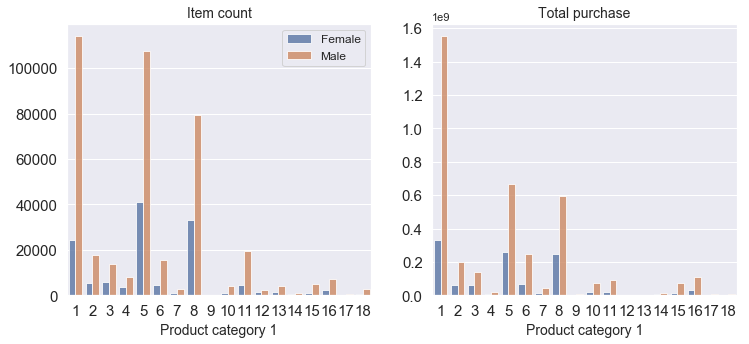

In [15]:
df_Tpurchase_by_PC1_Age = df.groupby(['Product_Category_1','Age']).agg({'Purchase':np.sum}).reset_index()
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
sns.countplot('Product_Category_1',hue='Age',data=df,alpha = 0.8,hue_order=age_order)
plt.title('Item count',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend(title='Age group',frameon=True,fontsize=12)
plt.tick_params(labelsize=15)
plt.subplot(122)
sns.barplot('Product_Category_1','Purchase',hue='Age',data=df_Tpurchase_by_PC1_Age,alpha = 0.8)
plt.title('Total purchase',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)

df_Tpurchase_by_PC1_Gender = df.groupby(['Product_Category_1','Gender']).agg({'Purchase':np.sum}).reset_index()
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
sns.countplot('Product_Category_1',hue='Gender',data=df,alpha = 0.8)
plt.title('Item count',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend(['Female','Male'],frameon=True,fontsize=12)
plt.tick_params(labelsize=15)
plt.subplot(122)
sns.barplot('Product_Category_1','Purchase',hue='Gender',data=df_Tpurchase_by_PC1_Gender,alpha = 0.8)
plt.title('Total purchase',fontsize=14)
plt.xlabel('Product category 1',fontsize=14)
plt.ylabel('')
plt.legend().set_visible(False)
plt.tick_params(labelsize=15)

In general, 
* Male shopped more than Female
* Single shopped more than Married
* Customers from *City B* shopped the most
* Customers who has resided in their city for 1 year shopped the most 
* *Product_category_1 #1,5,8* were the most selling 
* *Product_category_1 #1* made the most profit

These relationships between different features can be investigated further to set the new marketing strategies to maximize the profit of the retail store (possibly for the future black Fridays). For example, the retail store may consider doing more advertisements targetting their unmarried male customers in *City B* on *product_category_1 #1*.

# Feature engineering for model fitting

While the ordinal categorical features can be simply encoded with integers, the nominal categorical features need to be one-hot-encoded. In this case, however, the number of unique entires for `User_ID` and `Product_ID` is too big and one-hot-encoding these features will unnecessarily increase the data dimension and therefore cardinality. In real case, some other technique like *feature hashing* may be considered, but for the scope of this project where these two are being considered to be the source of data leakage, thses two features will be simply encoded with integers. Except for `Gender` and `Marital_Status` which are binary, all other nominal categorical data will be, however, one-hot-encoded.

In [16]:
le_U_ID = LabelEncoder()
df['User_ID'] = le_U_ID.fit_transform(df['User_ID'])
le_P_ID = LabelEncoder()
df['Product_ID'] = le_P_ID.fit_transform(df['Product_ID'])
df['Gender'] = np.where(df['Gender']=='M',1,0) # Female: 0, Male: 1
df_Age = pd.get_dummies(df.Age)
df_CC = pd.get_dummies(df.City_Category)
df_SIC = pd.get_dummies(df.Stay_In_Current_City_Years)
df_encoded = pd.concat([df,df_Age,df_CC,df_SIC],axis=1)
df_encoded.drop(['Age','City_Category','Stay_In_Current_City_Years'],axis=1,inplace=True)

# ML model (Random Forest) fitting (Case 1):

Since most features are discrete, *Random Forest Regressor* is expected to fit the data well. Since the given dataset contains ~half million entries, using all of them may cause running-time issue on my machine when trying to do some iterative works like generating the learning curve. Therefore, only the fraction (1/50) of its data (~10k) will be randomly sampled for initial ML model fitting attempts.
#### Random sampling and train/test split

In [17]:
df_frac = df_encoded.sample(frac=0.02,random_state=100)
X = df_frac.drop(['Purchase'], axis=1).astype('float')
y = df_frac['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Hyperparameter selection through 3-fold cross-validation: RMSE

Best parameter: {'n_estimators': 300}
Best score: 2984.34


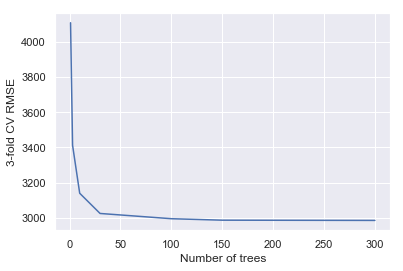

In [18]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=3,scoring='neg_mean_squared_error').fit(X_train_scaled,y_train)
plt.figure()
plt.plot(list(param_grid.values())[0],(-1*grid_rf.cv_results_['mean_test_score'])**0.5)
plt.xlabel('Number of trees')
plt.ylabel('3-fold CV RMSE')
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format((-1*grid_rf.best_score_)**0.5))

Only the number of trees used in the ensemble (`n_estimators`) was roughly scanned for the initial attempt.
As the number of tree in RF increased, the average CV RMSE decreased. While it seemed to be saturated at `n_estimators`=~100, it was difficult to tell why the model was still suffering with high RMSE.

By considering `max_depth`, more optimized parameters can be searched up.

In [19]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300],'max_depth':[1,3,5,7,9]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=3,scoring='neg_mean_squared_error').fit(X_train_scaled,y_train)

In [20]:
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format((-1*grid_rf.best_score_)**0.5))

Best parameter: {'max_depth': 9, 'n_estimators': 300}
Best score: 2959.75


In this specific random grid Search,`max_depth` = 7 and `n_estimators` = 150 were found to be optimal. With the two parameters optimized, however, the 3-fold CV score is still quite low. 
Next, the learning curve can be considered to understand the performance of the model better.

#### Model investigation by the learning curve

In [21]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(max_depth=7, n_estimators=150), X_train_scaled, y_train, cv=3, scoring='neg_mean_squared_error')

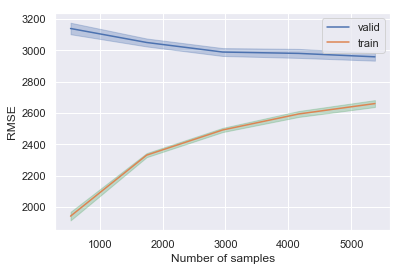

In [22]:
train_scores = (-1*train_scores)**0.5
valid_scores = (-1*valid_scores)**0.5
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes,valid_scores_mean,label='valid')
plt.plot(train_sizes,train_scores_mean,label='train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3,color="g")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,valid_scores_mean + valid_scores_std, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.legend()

From the learning curve, it is shown that the RF model with `max_depth` = 7 and `n_estimators` = 300 is suffering with a variance problem. We may consider investigating the feature importance to remove some features. 
#### Feature importance

Text(0.5, 0, 'relative importance')

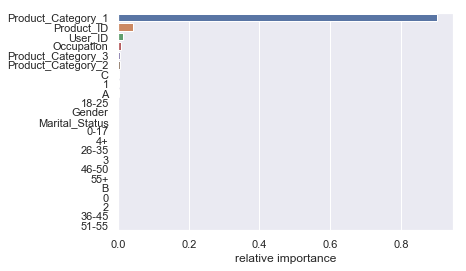

In [23]:
rf = RandomForestRegressor(max_depth=7, n_estimators=150).fit(X_train_scaled,y_train)
f_im = rf.feature_importances_.round(3)
ser_rank = pd.Series(f_im,index=X.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank.index,x=ser_rank.values,palette='deep')
plt.xlabel('relative importance')

This tells that the current model heavily relies on `Product_Category_1` (followed by `Product_ID` and `User_ID`) to make prediction on `Purchase`. This was somewhat expected from EDA as they are directly related to the amount of `Purchase` that the customers make. I interpret this as a strong sign of **data leakage**. Therefore in Case 2, these suspicious features will be removed in training the second model.

Anyways, this can be trained with the entire dataset available to mitigate the high variance issue and its performance can be evaluated on the test set.

#### Utilize the entire dataset for evalution on test set: RMSE

In [24]:
X = df_encoded.drop(['Purchase'], axis=1).astype('float')
y = df_encoded['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(max_depth=7, n_estimators=150).fit(X_train_scaled,y_train)
y_predicted = rf.predict(X_test_scaled)
print('Test set RMSE: {:.3f}'.format(mean_squared_error(y_test,y_predicted)**0.5))

Test set RMSE: 2911.303


# ML model (Random Forest) fitting (Case 2):
#### Data cleaning - removing leackage-causing features &  Random sampling and train/test split

In [25]:
df_ocup = pd.get_dummies(df.Occupation)
df_encoded = pd.concat([df_encoded,df_ocup],axis=1)
df_encoded.drop(['Occupation'],axis=1,inplace=True)

In [26]:
df_frac = df_encoded.sample(frac=0.02,random_state=100)
X = df_frac.drop(['Purchase','User_ID','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
y = df_frac['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

#### Hyperparameter selection through 3-fold cross-validation: RMSE

In [27]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300],'max_depth':[1,3,5,7,9]}
grid_rf = GridSearchCV(RandomForestRegressor(),param_grid,cv=3,scoring='neg_mean_squared_error').fit(X_train,y_train)

In [28]:
print('Best parameter: {}'.format(grid_rf.best_params_))
print('Best score: {:.2f}'.format((-1*grid_rf.best_score_)**0.5))

Best parameter: {'max_depth': 5, 'n_estimators': 150}
Best score: 4936.78


#### Model investigation by the learning curve

In [29]:
train_sizes, train_scores, valid_scores = learning_curve(RandomForestRegressor(max_depth=3, n_estimators=300), X_train, y_train, cv=3, scoring='neg_mean_squared_error')

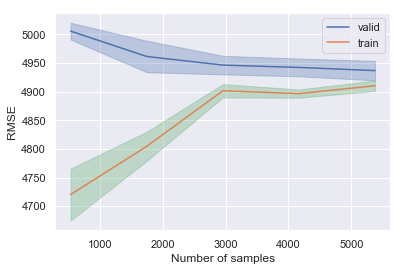

In [30]:
train_scores = (-1*train_scores)**0.5
valid_scores = (-1*valid_scores)**0.5
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.plot(train_sizes,valid_scores_mean,label='valid')
plt.plot(train_sizes,train_scores_mean,label='train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3,color="g")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,valid_scores_mean + valid_scores_std, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.legend()

Considering only the low-level features, now it seems like the model suffers from high bias issue. Knowing that this dataset is artificial, it could possibly be that the given low-level features do not simply have enough predictive power for `Purchase`.
#### Feature importance

Text(0.5, 0, 'relative importance')

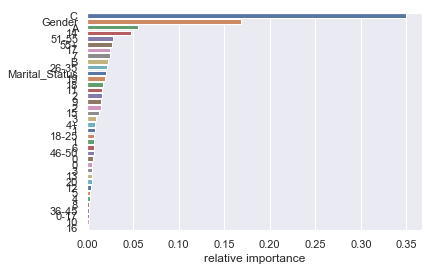

In [31]:
rf = RandomForestRegressor(max_depth=3, n_estimators=300).fit(X_train,y_train)
f_im = rf.feature_importances_.round(3)
ser_rank = pd.Series(f_im,index=X.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank.index,x=ser_rank.values,palette='deep')
plt.xlabel('relative importance')

#### Evalution on test set: RMSE

In [32]:
y_predicted = rf.predict(X_test)
print('Test set RMSE: {:.3f}'.format(mean_squared_error(y_test,y_predicted)**0.5))

Test set RMSE: 4875.171


From the learning curve, it seems like utilizing more training set would not help much. With 1/50th of the dataset, this model achieves RMSE of ~4876.105 on the test set.

# Conclusion

In this project, the blackfriday dataset has been explored. While EDA revealed some interesting relationships among different features, for the purpose of predicting customer's ***Purchase***, the top three features useful included ***Product_Category_1***, ***Product_ID*** and ***User_ID***. With a roughly tuned Random Forest model with `max_depth` = 9 and `n_estimators` = 300, the ***RMSR*** for predicting ***Purchase*** of this model was shown to be ~***2912***. 

However, if the goal is to predict `Purchase` for the new customer who have never been in the store, those customer-specific and product-specific information cannot be utilized. In this case, only the low-level features can be utilized to train the model. In this case, the model perfornace of the test set was ~***4876***.

The results are quite dissapointing. However, at the same time, it looks quite reasonable for this synthetically generated dataset where the given low-level features showed to have very weak relationships with the target variable. 

For further optimization of the model, the parameters of RF can be tuned more intensively (by exploring more/deeper trees) or other more sophisticated ML models, such as Gradient Boosted Decision Trees and neural network, can be investigated on this dataset to overcome the bias problem.